# Quantum Computing and Quantum Machine Learning - Project 1
## FYS5419/9419, University of Oslo, Spring 2025

In [1]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import qiskit as qk
from qiskit_aer import Aer

In [11]:
# First some definitions of variables that we will use across the exercises
basis_0, basis_1 = np.array([1, 0]), np.array([0, 1])
Pauli_X = np.array([[0, 1], [1, 0]])
Pauli_Y = np.array([[0, -1j], [1j, 0]])
Pauli_Z = np.array([[1, 0], [0, -1]])
Id = np.array([[1, 0], [0, 1]])

CNOT = np.array([[1,0,0,0],
                 [0,1,0,0],
                 [0,0,0,1],
                 [0,0,1,0]])
CNOT_10 = np.array([[1,0,0,0],
                 [0,0,0,1],
                 [0,0,1,0],
                 [0,1,0,0]])
SWAP = np.array([[1,0,0,0],
                 [0,0,1,0],
                 [0,1,0,0],
                 [0,0,0,1]])
S_dag = np.array([[1, 0], [0, -1j]])

### Part a)

**Mathematical Background:**

In quantum computing, the basis states $|0\rangle$ and $|1\rangle$ are represented as vectors $[1, 0]^T$ and $[0, 1]^T$, respectively. The Pauli matrices $X$, $Y$, and $Z$ are fundamental operators in quantum mechanics and are defined as:

$$
X = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}, \quad Y = \begin{bmatrix} 0 & -i \\ i & 0 \end{bmatrix}, \quad Z = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}
$$

The Hadamard gate $H$ and the phase gate $S$ are defined as:

$$
H = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}, \quad S = \begin{bmatrix} 1 & 0 \\ 0 & i \end{bmatrix}
$$

Bell states are maximally entangled quantum states of two qubits, defined as:

$$
|\Phi^+\rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle), \quad |\Phi^-\rangle = \frac{1}{\sqrt{2}} (|00\rangle - |11\rangle)
$$
$$
|\Psi^+\rangle = \frac{1}{\sqrt{2}} (|01\rangle + |10\rangle), \quad |\Psi^-\rangle = \frac{1}{\sqrt{2}} (|01\rangle - |10\rangle)
$$

In [12]:
def apply_pauli_matrices_to_state(state, name):
    matrices = [Pauli_X, Pauli_Y, Pauli_Z]
    print("Basis state |" + name + ">:")
    print(state)
    print("\nApplying Pauli matrices to |" + name + ">:")
    for matrix in matrices:
        print(f"{matrix} |{name}> = {matrix @ state}")
    print("")

apply_pauli_matrices_to_state(basis_0, "0")
apply_pauli_matrices_to_state(basis_1, "1")

Basis state |0>:
[1 0]

Applying Pauli matrices to |0>:
[[0 1]
 [1 0]] |0> = [0 1]
[[ 0.+0.j -0.-1.j]
 [ 0.+1.j  0.+0.j]] |0> = [0.+0.j 0.+1.j]
[[ 1  0]
 [ 0 -1]] |0> = [1 0]

Basis state |1>:
[0 1]

Applying Pauli matrices to |1>:
[[0 1]
 [1 0]] |1> = [1 0]
[[ 0.+0.j -0.-1.j]
 [ 0.+1.j  0.+0.j]] |1> = [0.-1.j 0.+0.j]
[[ 1  0]
 [ 0 -1]] |1> = [ 0 -1]



In [13]:
# Moving on to Hadamard and phase gates:
Hadamard = (1 / sqrt(2)) * np.array([[1, 1], [1, -1]])

def apply_phase(phase, state):
    gate = np.array([[1, 0], [0, np.exp(1j * phase)]])
    return gate @ state

def print_result(func, name):
    result_0 = func(basis_0)
    result_1 = func(basis_1)
    print(name + " :")
    print(f"|0> = {result_0}")
    print(f"|1> = {result_1}")

print_result(lambda state: Hadamard @ state, "Hadamard")
print_result(lambda state: apply_phase(np.pi, state), "Phase")


Hadamard :
|0> = [0.70710678 0.70710678]
|1> = [ 0.70710678 -0.70710678]
Phase :
|0> = [1.+0.j 0.+0.j]
|1> = [ 0.+0.0000000e+00j -1.+1.2246468e-16j]


In [14]:
# Bell states and CNOT gate
bell_phi_p = (1 / sqrt(2)) * np.array([1, 0, 0, 1])
bell_phi_m = (1 / sqrt(2)) * np.array([1, 0, 0, -1])
bell_psi_p = (1 / sqrt(2)) * np.array([0, 1, 1, 0])
bell_psi_m = (1 / sqrt(2)) * np.array([0, 1, -1, 0])

hadamard_4D = np.kron(Hadamard, Id)

def apply_hadamard_and_cnot():
    bell_hadamard = hadamard_4D @ bell_phi_p
    print("Hadamard applied to Bell state Phi+: ")
    print(bell_hadamard)
    bell_hadamard_cnot = CNOT @ bell_hadamard
    print("CNOT + Hadamard applied to Bell state Phi+: ")
    print(bell_hadamard_cnot)
    return bell_hadamard_cnot

def measure(state, basis, shots):
    probabilities = np.abs(state.flatten())**2
    results = np.random.choice(basis, size=shots, p=probabilities)
    counts = {}
    for base in basis:
        counts[base] = (results == base).sum()
    return counts

bell_hadamard_cnot = apply_hadamard_and_cnot()
results = measure(bell_hadamard_cnot, ["00", "01", "10", "11"], 10000)
print(results)

# Comparison with Qiskit
def measure_bell_state(repetitions=10000):
    backend = Aer.get_backend('aer_simulator')
    qc = qk.QuantumCircuit(2, 2)
    
    # Create a bell state
    qc.h(0)
    qc.cx(0, 1)
    
    # Apply Hadamard and CNOT
    qc.h(0)
    qc.cx(0, 1)
    
    qc.measure([0, 1], [0, 1])
    compiled_circuit = qk.transpile(qc, backend)
    job = backend.run(compiled_circuit, shots=repetitions)
    results = job.result().get_counts()
    return results

print("With Qiskit:")
print(measure_bell_state())

Hadamard applied to Bell state Phi+: 
[ 0.5  0.5  0.5 -0.5]
CNOT + Hadamard applied to Bell state Phi+: 
[ 0.5  0.5 -0.5  0.5]
{'00': 2435, '01': 2529, '10': 2569, '11': 2467}
With Qiskit:
{'11': 2533, '10': 2488, '00': 2465, '01': 2514}


### Part b)

**Mathematical Background:**

The Hamiltonian $H$ is given by:

$$
H = H_0 + \lambda H_I
$$

where $H_0$ is the non-interacting Hamiltonian and $H_I$ is the interaction Hamiltonian. The eigenvalues of $H$ can be found by solving the characteristic equation:

$$
\det(H - E I) = 0
$$

For the given parameters $E_1 = 0$, $E_2 = 4$, $V_{11} = 3$, $V_{22} = -3$, and $V_{12} = 0.2$, the eigenvalues are computed as functions of $\lambda$.

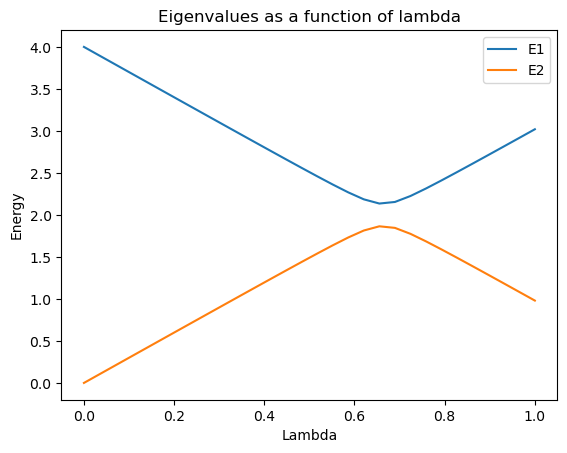

In [21]:
def EW_1(lambd):
    return 2 + sqrt((3 * lambd - 2)**2 + (0.2 * lambd) ** 2)

def EW_2(lambd):
    return 2 - sqrt((3 * lambd - 2)**2 + (0.2 * lambd) ** 2)

lambda_range = np.linspace(0.0, 1.0, 30)

def plot_eigenvalues():
    y_e1 = [EW_1(i) for i in lambda_range]
    y_e2 = [EW_2(i) for i in lambda_range]

    plt.plot(lambda_range, y_e1, label="E1")
    plt.plot(lambda_range, y_e2, label="E2")
    plt.legend()
    plt.xlabel("Lambda")
    plt.ylabel("Energy")
    plt.title("Eigenvalues as a function of lambda")
    plt.show()

plot_eigenvalues()

### Part c)

**Mathematical Background:**

The Variational Quantum Eigensolver (VQE) is a hybrid quantum-classical algorithm used to find the eigenvalues of a Hamiltonian. The algorithm works by preparing a parameterized quantum state $|\psi(\theta)\rangle$ and minimizing the expectation value of the Hamiltonian:

$$
E(\theta) = \langle \psi(\theta) | H | \psi(\theta) \rangle
$$

The minimization is performed using classical optimization techniques.

First of all, **some constants**

In [22]:
E_1 = 0
E_2 = 4
V_11 = 3
V_22 = -3
V_12 = 0.2
V_21 = V_12
eps = (E_1 + E_2) / 2
omega = (E_1 - E_2) / 2
c = (V_11 + V_22) / 2
omega_z = (V_11 - V_22) / 2
omega_x = V_12

These are mathematics and **helper functions**, which will help to prepare a 1-Qubit state, a Hamiltonian, and with transforming a given Pauli string into the Z basis:

In [23]:
def Rx(theta):
    return np.cos(theta/2) * Id - 1j * np.sin(theta/2) * Pauli_X

def Ry(phi):
    return np.cos(phi/2) * Id - 1j * np.sin(phi/2) * Pauli_Y

def prepare_state_1_qubit(args):
    state = np.array([1, 0])
    theta = args[0]
    phi = args[1]
    rx = Rx(theta)
    ry = Ry(phi)
    state = ry @ rx @ state
    return state

def prepare_Hamiltonian(x=0, y=0, z=0, I=0):
    return (x * Pauli_X) + (y * Pauli_Y) + (z * Pauli_Z) + (I * Id)

def transform_to_Z_basis(pauli_string):
    gates = {
        "X": Hadamard,
        "ZI": np.kron(Id, Id),
        "IZ": SWAP,
        "XI": np.kron(Hadamard, Id),
        "IX": np.kron(Hadamard, Id) @ SWAP,
        "YI": np.kron(S_dag @ Hadamard, Id),
        "IY": np.kron(S_dag @ Hadamard, Id) @ SWAP,
        "ZZ": CNOT_10,
        "XX": CNOT_10 @ np.kron(Hadamard, Hadamard),
        "YY": CNOT_10 @ np.kron(S_dag @ Hadamard, S_dag @ Hadamard),
        "ZX": CNOT_10 @ np.kron(Id, Hadamard),
        "XZ": CNOT_10 @ np.kron(Id, Hadamard) @ SWAP
    }
    return gates.get(pauli_string, None)

H_0 = prepare_Hamiltonian(z=omega, I=eps)
H_1 = prepare_Hamiltonian(x=omega_x, z=omega_z, I=c)

# H_0 and H_1 can be set globally, so that this function only takes lambda as the parameter
def create_Hamiltonian(lambd):
    return H_0 + lambd * H_1

Now for the actual VQE implementation, in which the ground state energy is inferred by means of transforming the Hadamard matrix into Pauli matrices in the Z basis.
The minimization process uses gradient descend to infer the optimal eigenvector angles. 

In [24]:
# Now for the actual VQE implementation:
def get_energy(angles, lmb, number_shots):
    theta, phi = angles[0], angles[1]
    init_state = prepare_state_1_qubit([theta, phi])
    
    measure_z = measure(init_state, ["0", "1"], number_shots)
    exp_val_z = (omega + lmb*omega_z)*(number_shots - 2*measure_z["1"]) / number_shots

    measure_x = measure(transform_to_Z_basis("X") @ init_state, ["0", "1"], number_shots)
    exp_val_x = lmb*omega_x*(number_shots - 2*measure_x["1"]) / number_shots
    
    exp_val_i = (eps + c*lmb)
    exp_val = (exp_val_z + exp_val_x + exp_val_i)
    return exp_val

def minimize_energy(lmb, number_shots, angles_0, learning_rate, max_epochs):
    angles = angles_0
    epoch = 0
    delta_energy = 1
    energy = get_energy(angles, lmb, number_shots)
    while (epoch < max_epochs) and (delta_energy > 1e-4):
        grad = np.zeros_like(angles)
        for idx in range(angles.shape[0]):
            angles_temp = angles.copy()
            angles_temp[idx] += np.pi/2 
            E_plus = get_energy(angles_temp, lmb, number_shots)
            angles_temp[idx] -= np.pi
            E_minus = get_energy(angles_temp, lmb, number_shots)
            grad[idx] = (E_plus - E_minus)/2 
        angles -= learning_rate*grad
        new_energy = get_energy(angles, lmb, number_shots)
        delta_energy = np.abs(new_energy - energy)
        energy = new_energy
        epoch += 1
    return angles, epoch, (epoch < max_epochs), energy, delta_energy

def VQE(n_angles):
    number_shots_search = 10_000
    learning_rate = 0.3
    max_epochs = 400
    min_energy = np.zeros(len(lambda_range))
    epochs = np.zeros(len(lambda_range))
    for index, lmb in enumerate(lambda_range):
        memory = 0
        angles_0 = np.random.uniform(low = 0, high = np.pi, size = n_angles)
        angles, epochs[index], converged, min_energy[index], delta_energy = minimize_energy(lmb, number_shots_search, angles_0, learning_rate, max_epochs)
        if epochs[index] < (epochs[index-1] - 5):
            angles_0 = np.random.uniform(low = 0, high = np.pi, size = n_angles)
            angles, epochs[index], converged, min_energy[index], delta_energy = minimize_energy(lmb, number_shots_search, angles_0, learning_rate, max_epochs)
        print(f'Lambda = {lmb}, Energy = {min_energy[index]}, Epochs = {epochs[index]}, Converged = {converged}, Delta Energy = {delta_energy}, Angles = {angles}')
    return min_energy

We will also write functions which minimize the energy using a scipy minimizer, and one which simply finds all eigenvalues of the hamiltonian:

Lambda = 0.0, Energy = 0.0007999999999999119, Epochs = 16.0, Converged = True, Delta Energy = 0.0, Angles = [0.01068687 0.01511431 1.14379537 2.40048586]
Lambda = 0.034482758620689655, Energy = 0.10346344827586207, Epochs = 10.0, Converged = True, Delta Energy = 1.5172413793118622e-05, Angles = [-1.30016465e-03 -2.36993809e-03  1.04900374e+00  1.91527359e+00]
Lambda = 0.06896551724137931, Energy = 0.2069710344827589, Epochs = 13.0, Converged = True, Delta Energy = 4.137931034486897e-05, Angles = [3.14104199 3.13572143 1.22525101 0.88699135]
Lambda = 0.10344827586206896, Energy = 0.310543448275862, Epochs = 12.0, Converged = True, Delta Energy = 6.206896551730345e-05, Angles = [ 0.00183466 -0.00379865  1.08568309  1.74157255]
Lambda = 0.13793103448275862, Energy = 0.414088275862069, Epochs = 9.0, Converged = True, Delta Energy = 6.896551724144828e-05, Angles = [ 1.32767062e-02 -5.62525709e-04  8.85547368e-01  2.47880917e+00]
Lambda = 0.1724137931034483, Energy = 0.5171310344827584, Epoc

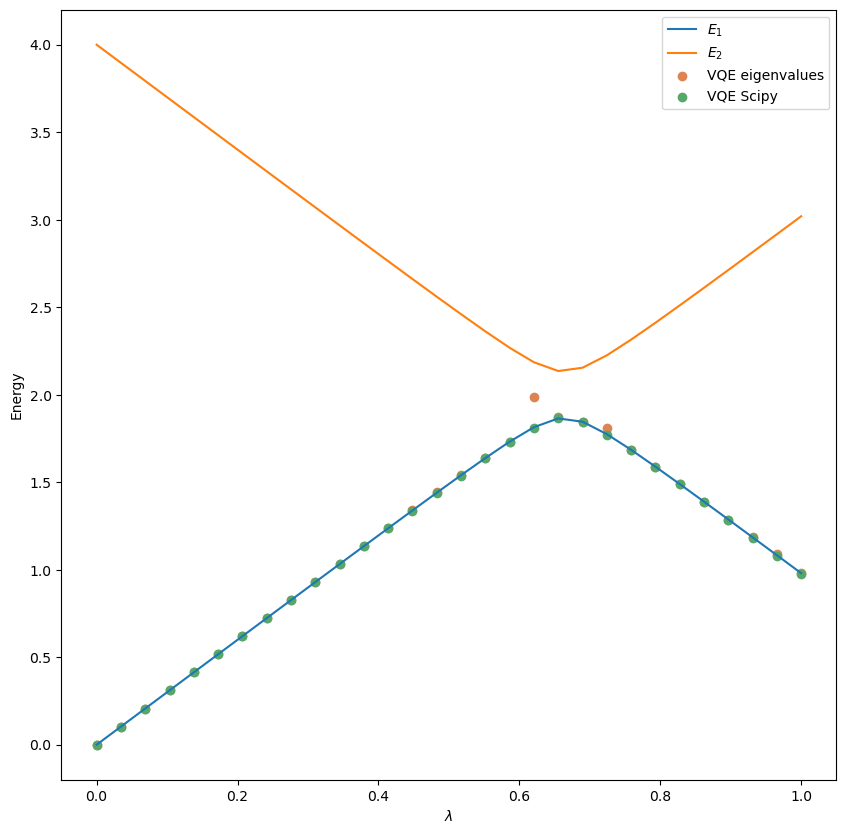

In [25]:
def minimize_energy_scipy(fnc):
    number_shots = 10_000
    min_energy = np.zeros(len(lambda_range))
    for index, lmb in enumerate(lambda_range):
        angles_start = np.random.uniform(low = 0, high = np.pi, size = 4)
        res = minimize(fnc, angles_start, args = (lmb, number_shots), method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
        min_energy[index] = res.fun
    return min_energy
    

def find_eigenvalues_scipy(hamiltonian_func):
    h_len = len(hamiltonian_func(0))
    eigvals = np.zeros((len(lambda_range), h_len))
    for index, lmb in enumerate(lambda_range):
        H = hamiltonian_func(lmb)
        eigen, _ = np.linalg.eigh(H)
        eigvals[index] = eigen
    return eigvals

def plot_results(min_energy_VQE, min_energy_scipy=np.array(0), eigvals_ana=np.array(0)):
    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    if eigvals_ana.any():
        for i in range(len(eigvals_ana[0,:])):
            axs.plot(lambda_range, eigvals_ana[:,i], label=f'$E_{i+1}$')
    if min_energy_VQE.any():
        axs.scatter(lambda_range, min_energy_VQE, label = 'VQE eigenvalues', color = '#dd8452')
    if min_energy_scipy.any():
        axs.scatter(lambda_range, min_energy_scipy, label = 'VQE Scipy', color = '#55a868')
    axs.set_xlabel(r'$\lambda$')
    axs.set_ylabel('Energy')
    plt.legend()
    plt.show()

def perform_VQE_and_plot_results(n_angles, create_Hamiltonian_func):
    min_energy = VQE(n_angles)
    min_energy_scipy = minimize_energy_scipy(get_energy)
    eigvals_ana = find_eigenvalues_scipy(create_Hamiltonian_func)
    plot_results(min_energy_VQE=min_energy, min_energy_scipy=min_energy_scipy, eigvals_ana=eigvals_ana)

perform_VQE_and_plot_results(4, create_Hamiltonian)

### Part d)

The Hamiltonian for a two-qubit system is given by:

$$
H = H_0 + H_I
$$

where $H_0$ is the non-interacting Hamiltonian and $H_I$ is the interaction Hamiltonian. The von Neumann entropy is used to measure entanglement and is defined as:

$$
S(\rho) = -\text{Tr}(\rho \log_2 \rho)
$$

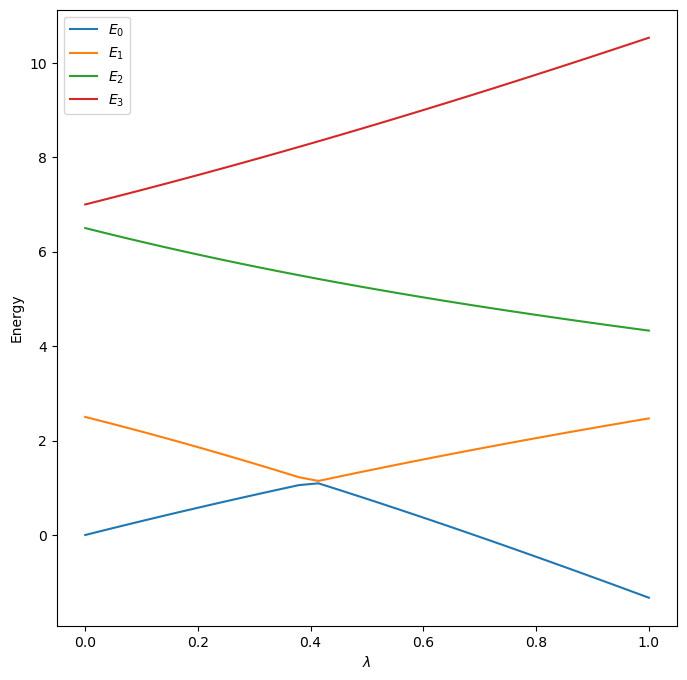

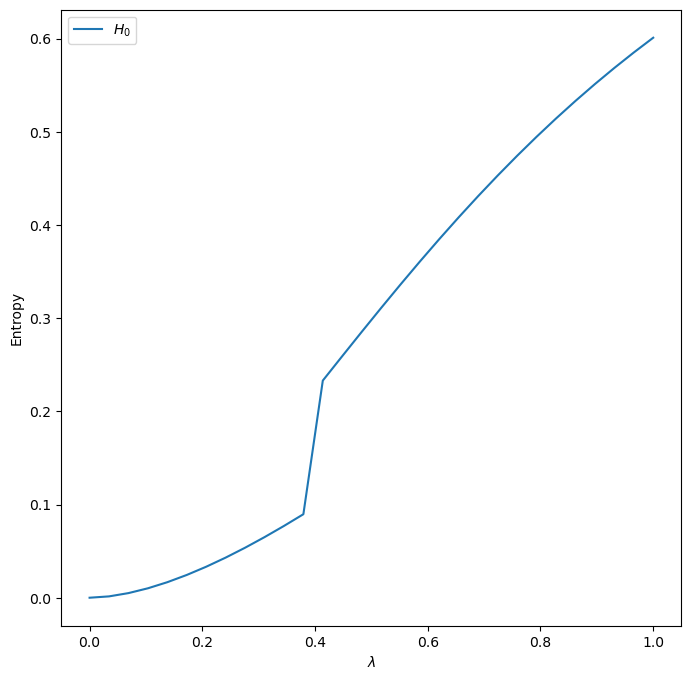

In [26]:
# Part d) Two-qubit system and von Neumann entropy

Hx = 2.0
Hz = 3.0
Energiesnoninteracting = [0.0, 2.5, 6.5, 7.0]
H_0 = np.diag(Energiesnoninteracting)
H_1 = Hx * np.kron(Pauli_X, Pauli_X) + Hz * np.kron(Pauli_Z, Pauli_Z)

def trace_out(state, index):
    density = np.outer(state, np.conj(state))
    if index == 0:
        op0 = np.kron(basis_0, Id)
        op1 = np.kron(basis_1, Id)
    elif index == 1:
        op0 = np.kron(Id, basis_0)
        op1 = np.kron(Id, basis_1)
    return op0.conj() @ density @ op0.T + op1.conj() @ density @ op1.T

eigenvalues = []
entropy = np.zeros((len(lambda_range), 4))
for index, lmb in enumerate(lambda_range):
    Hamilt = create_Hamiltonian(lmb)
    eigvals, eigvecs = np.linalg.eigh(Hamilt)
    eigenvalues.append(eigvals)
    for i in range(4):
        sub_density = trace_out(eigvecs[:, i], 0)
        lmb_density = np.linalg.eigvalsh(sub_density)
        lmb_density = np.ma.masked_equal(lmb_density, 0).compressed()
        entropy[index, i] = -np.sum(lmb_density*np.log2(lmb_density))
eigenvalues = np.array(eigenvalues)

def plot_energies_and_entropy():
    fig, axs = plt.subplots(1, 1, figsize=(8, 8))
    for i in range(4):
        axs.plot(lambda_range, eigenvalues[:, i], label=f'$E_{i}$')
    axs.set_xlabel(r'$\lambda$')
    axs.set_ylabel('Energy')
    axs.legend()
    plt.show()

    fig, axs = plt.subplots(1, 1, figsize=(8, 8))
    for i in range(1):
        axs.plot(lambda_range, entropy[:, i], label=f'$H_{i}$')
    axs.set_xlabel(r'$\lambda$')
    axs.set_ylabel('Entropy')
    axs.legend()
    plt.show()

plot_energies_and_entropy()

### Part e) (Score: 15pt)

**Mathematical Background:**

The VQE algorithm is extended to a two-qubit system. The Hamiltonian is now a 4x4 matrix, and the expectation value of the Hamiltonian is computed using a parameterized two-qubit state.

Lambda = 0.0, Energy = 0.0, Epochs = 14.0, Converged = True, Delta Energy = 0.0, Angles = [ 3.14678972e+00  3.14537784e+00 -6.53667317e-04  5.55291786e-03]
Lambda = 0.034482758620689655, Energy = 0.10309655172413779, Epochs = 50.0, Converged = True, Delta Energy = 5.172413793275155e-06, Angles = [-0.00126374 -0.01753005  0.00325743  0.00095685]
Lambda = 0.06896551724137931, Energy = 0.20358103448275866, Epochs = 18.0, Converged = True, Delta Energy = 9.137931034475244e-05, Angles = [ 0.00220746 -0.0511734   0.00424292  0.00752208]
Lambda = 0.10344827586206896, Energy = 0.3069310344827585, Epochs = 32.0, Converged = True, Delta Energy = 7.758620689735096e-05, Angles = [ 0.00443237 -0.05392056  3.1340366   3.14484608]
Lambda = 0.13793103448275862, Energy = 0.40270344827586246, Epochs = 79.0, Converged = True, Delta Energy = 6.551724137926485e-05, Angles = [ 0.00460929 -0.0807228   0.00626608  0.00198045]
Lambda = 0.1724137931034483, Energy = 0.5015327586206899, Epochs = 197.0, Converged 

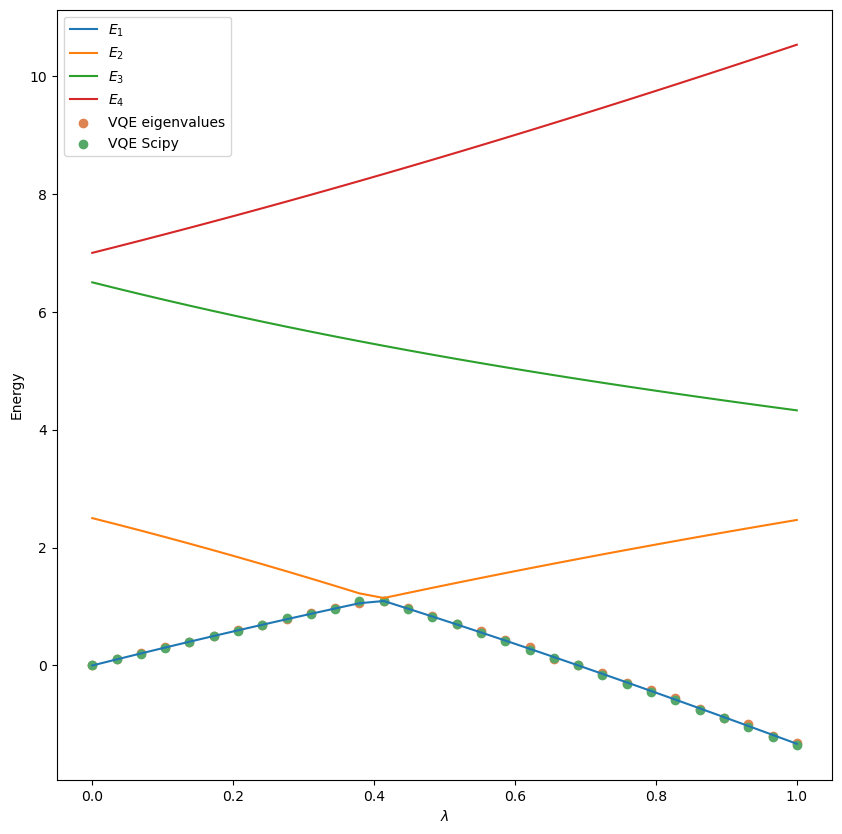

In [27]:
# Part e) VQE for two-qubit system

def apply_to_qubit(operator, qubit_index):
    if qubit_index == 0:
        return np.kron(operator, Id)
    elif qubit_index == 1:
        return np.kron(Id, operator)

def prepare_state_2_qubit(args):
    theta0, phi0, theta1, phi1 = args[0], args[1], args[2], args[3]
    qubit = np.array([1, 0, 0, 0])
    Rx0 = Rx(theta0)
    Ry0 = Ry(phi0)
    Rx1 = Rx(theta1)
    Ry1 = Ry(phi1)
    state = apply_to_qubit(Rx0, 0) @ qubit
    state = apply_to_qubit(Ry0, 0) @ state
    state = apply_to_qubit(Rx1, 1) @ state
    state = apply_to_qubit(Ry1, 1) @ state
    return CNOT @ state

def get_energy(angles, lmb, number_shots):
    Hx = 2.0 
    Hz = 3.0
    eps00, eps01, eps10, eps11 = np.array([0.0, 2.5, 6.5, 7.0])
    A = (eps00 + eps01 + eps10 + eps11) / 4.0
    B = (eps00 - eps01 + eps10 - eps11) / 4.0
    C = (eps00 + eps01 - eps10 - eps11) / 4.0
    D = (eps00 - eps01 - eps10 + eps11) / 4.0
    
    init_state = prepare_state_2_qubit(angles)

    measure_iz = measure(transform_to_Z_basis("IZ") @ init_state, ["00", "01", "10", "11"], number_shots)
    measure_zi = measure(init_state, ["00", "01", "10", "11"], number_shots)
    measure_zz = measure(transform_to_Z_basis("ZZ") @ init_state, ["00", "01", "10", "11"], number_shots)
    measure_xx = measure(transform_to_Z_basis("XX") @ init_state, ["00", "01", "10", "11"], number_shots)
    
    exp_vals = np.zeros(4)
    measures = np.array([measure_iz, measure_zi, measure_zz, measure_xx])
    constants = np.array([B, C, D + lmb*Hz, lmb*Hx])
    for index in range(len(exp_vals)):
        exp_vals[index] = measures[index]["00"] + measures[index]["01"] - measures[index]["10"] - measures[index]["11"]
    exp_val = A + np.sum(constants * exp_vals) / number_shots
    return exp_val

perform_VQE_and_plot_results(4, create_Hamiltonian)

### Part f) (Score: 20pt)

**Mathematical Background:**

The Lipkin Hamiltonian for $J=1$ and $J=2$ is given by:

$$
H_{J=1} = \begin{pmatrix} -\epsilon & 0 & -V \\ 0 & 0 & 0 \\ -V & 0 & \epsilon \end{pmatrix}, \quad H_{J=2} = \begin{pmatrix} -2\epsilon & 0 & \sqrt{6}V & 0 & 0 \\ 0 & -\epsilon + 3W & 0 & 3V & 0 \\ \sqrt{6}V & 0 & 4W & 0 & \sqrt{6}V \\ 0 & 3V & 0 & \epsilon + 3W & 0 \\ 0 & 0 & \sqrt{6}V & 0 & 2\epsilon \end{pmatrix}
$$

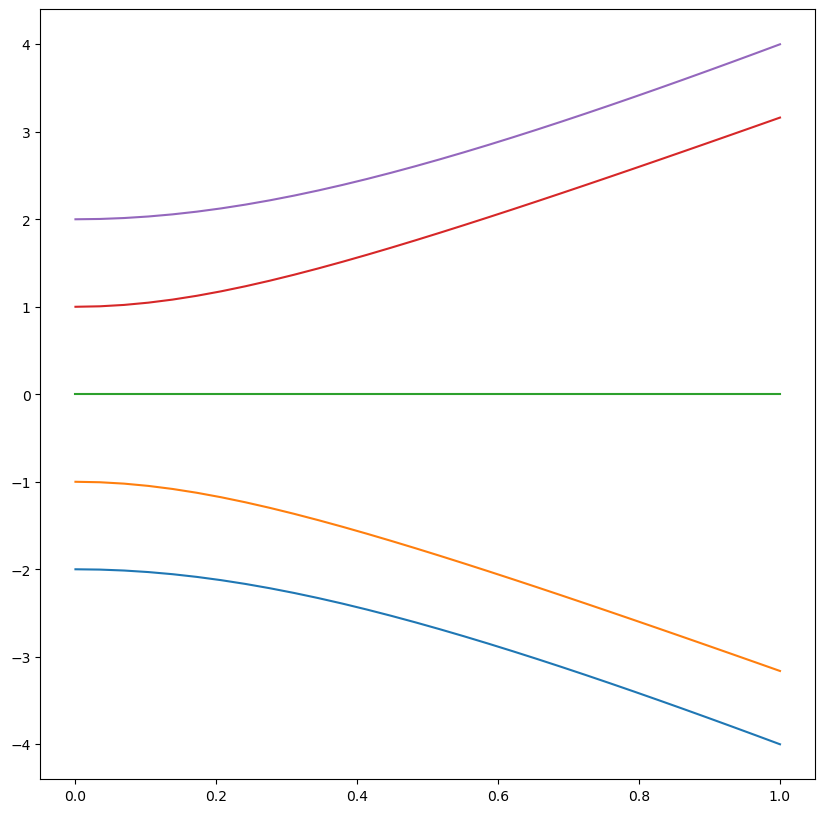

In [28]:
# Part f) Lipkin Hamiltonian for J=1 and J=2

epsilon = 1
H_0 = epsilon * np.diag([-2, -1, 0, 1, 2])

H_1 = np.zeros((5, 5))
H_1[2, 0] = np.sqrt(6)
H_1[3, 1] = 3
H_1[4, 2] = H_1[2, 0]
H_1 = H_1 + H_1.T

eigvals = find_eigenvalues_scipy(create_Hamiltonian)
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
for i in range(5):
    axs.plot(lambda_range, eigvals[:,i], label=f'$E_{i+1}$')
plt.show()

### Part g) (Score: 20pt)

**Mathematical Background:**

The VQE algorithm is applied to the Lipkin Hamiltonian for $J=1$ and $J=2$. The Hamiltonian is rewritten in terms of Pauli matrices, and the eigenvalues are computed using the VQE method.

Lambda = 0.0, Energy = -1.9998, Epochs = 14.0, Converged = True, Delta Energy = 0.0, Angles = [3.14130015 3.14471206 0.00477762 0.00557728]
Lambda = 0.034482758620689655, Energy = -2.0043234270181225, Epochs = 24.0, Converged = True, Delta Energy = 3.739447443207311e-05, Angles = [ 3.14023238e+00  3.14443682e+00  2.30883687e-03 -8.34819745e-02]
Lambda = 0.06896551724137931, Energy = -2.0096167974087913, Epochs = 22.0, Converged = True, Delta Energy = 8.115409336584278e-05, Angles = [0.00583282 0.00462929 3.14254658 2.95988142]
Lambda = 0.10344827586206896, Energy = -2.0316058765578324, Epochs = 22.0, Converged = True, Delta Energy = 9.774978723964267e-05, Angles = [ 3.13851461  3.15744445  0.00591629 -0.24621356]
Lambda = 0.13793103448275862, Energy = -2.0546955429155696, Epochs = 144.0, Converged = True, Delta Energy = 2.9542635748835977e-05, Angles = [ 3.14340055  3.16117097  0.00435738 -0.3322141 ]
Lambda = 0.1724137931034483, Energy = -2.087563815815077, Epochs = 264.0, Converged =

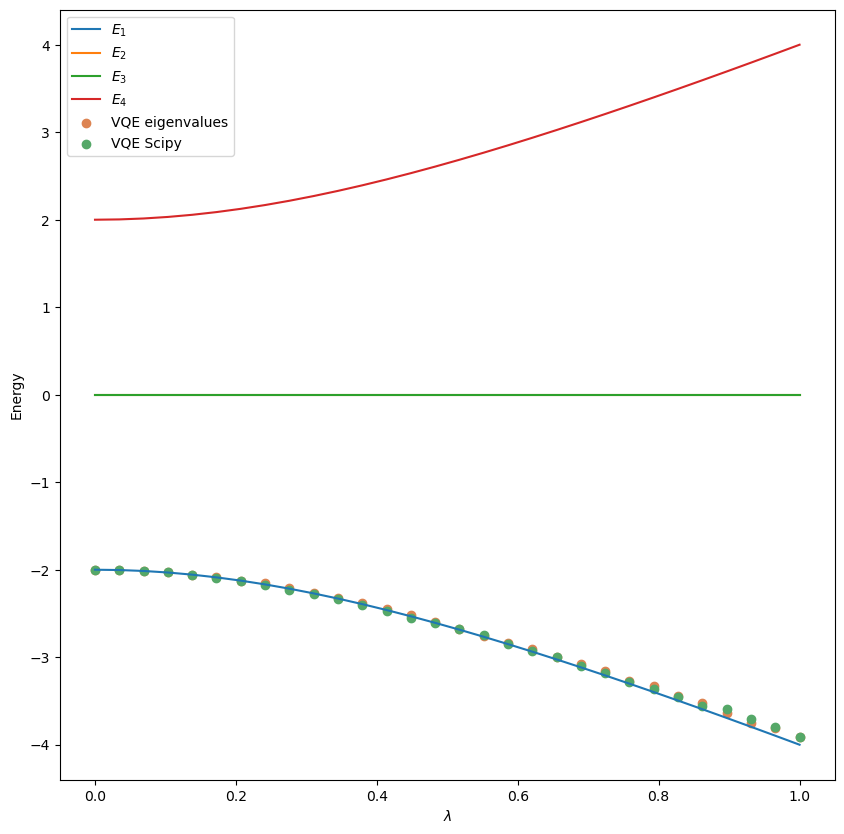

Lambda = 0.0, Energy = -1.0, Epochs = 15.0, Converged = True, Delta Energy = 0.0, Angles = [0.01084026 3.13945268]
Lambda = 0.034482758620689655, Energy = -1.005641379310345, Epochs = 27.0, Converged = True, Delta Energy = 9.65517241380276e-05, Angles = [3.14482466 0.10686111]
Lambda = 0.06896551724137931, Energy = -1.0253724137931035, Epochs = 58.0, Converged = True, Delta Energy = 5.5172413793158626e-05, Angles = [3.14666765 0.20732654]
Lambda = 0.10344827586206896, Energy = -1.0392206896551723, Epochs = 52.0, Converged = True, Delta Energy = 6.896551724366873e-06, Angles = [3.14235666 0.30354293]
Lambda = 0.13793103448275862, Energy = -1.0704620689655173, Epochs = 400.0, Converged = False, Delta Energy = 0.01832413793103438, Angles = [-0.00385079 -2.75036466]
Lambda = 0.1724137931034483, Energy = -1.1285379310344827, Epochs = 74.0, Converged = True, Delta Energy = 3.448275862072414e-05, Angles = [1.01701456e-03 3.62094515e+00]
Lambda = 0.20689655172413793, Energy = -1.16263448275862

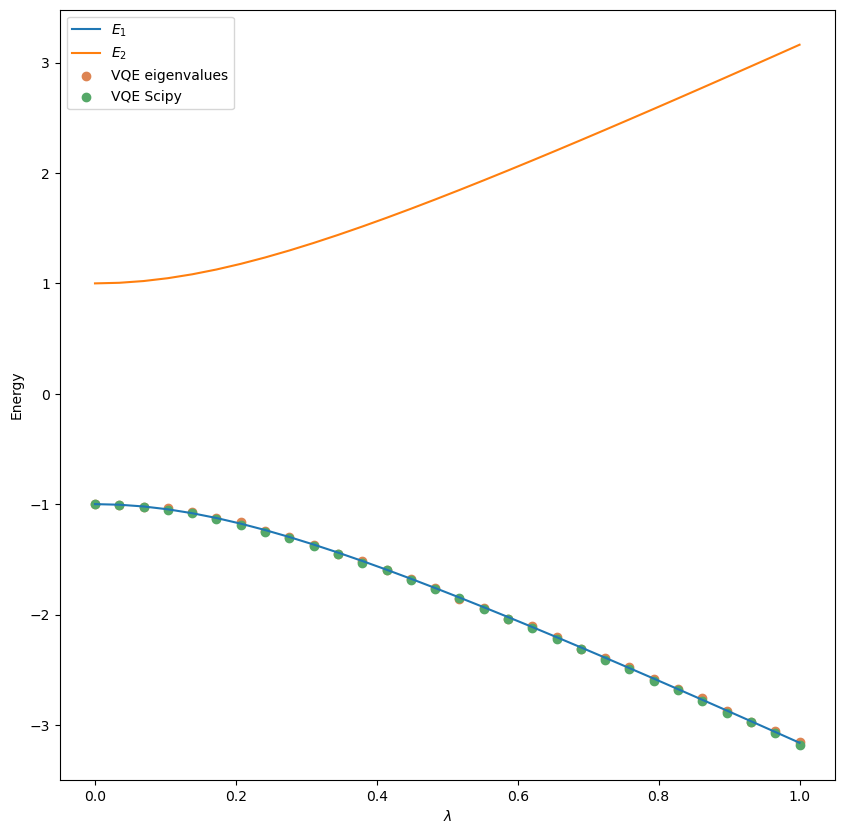

In [29]:
# Part g) VQE for Lipkin Hamiltonian

E, W = 1, 0
def Hamiltonian(lambd):
    V = lambd
    term1 = W * np.kron(Id, Id)
    term2 = (W-E) * np.kron(Pauli_Z, Id)
    term3 = -(W+E) * np.kron(Id, Pauli_Z)
    term4 = -W * np.kron(Pauli_Z, Pauli_Z)
    term5 = np.sqrt(6)/2*V * np.kron(Id, Pauli_X)
    term6 = np.sqrt(6)/2*V * np.kron(Pauli_X, Id)
    term7 = np.sqrt(6)/2*V * np.kron(Pauli_Z, Pauli_X)
    term8 = -np.sqrt(6)/2*V * np.kron(Pauli_X, Pauli_Z)
    
    H_135= term1+term2+term3+term4+term5+term6+term7+term8
    H_24=3*W*Id-E*Pauli_Z+3*V*Pauli_X
    return H_135, H_24

def get_energy(angles, lmb, number_shots):
    V = lmb
    init_state = prepare_state_2_qubit(angles)
    pauli_strings = ["ZI", "IZ", "ZZ", "IX", "XI", "ZX", "XZ"]
    measurements = []
    for p_str in pauli_strings:
        qubit = transform_to_Z_basis(p_str) @ init_state
        measurements.append(measure(qubit, ["00", "01", "10", "11"], number_shots))
    
    exp_vals = np.zeros(len(measurements))
    constants = np.array([(W-E), -(W+E), -W, np.sqrt(6)/2*V, np.sqrt(6)/2*V, np.sqrt(6)/2*V, -np.sqrt(6)/2*V])
    for index in range(len(exp_vals)):
        exp_vals[index] = measurements[index]["00"] + measurements[index]["01"] - measurements[index]["10"] - measurements[index]["11"]
    exp_val = W + np.sum(constants * exp_vals) / number_shots
    return exp_val

perform_VQE_and_plot_results(4, lambda lmb: Hamiltonian(lmb)[0])

def get_energy(angles, lmb, number_shots):
    V = lmb
    init_state = prepare_state_1_qubit(angles)
    measure_z = measure(init_state, ["0", "1"], number_shots)
    exp_val_z = -E * (measure_z["0"] - measure_z["1"]) / number_shots
    measure_x = measure(transform_to_Z_basis("X") @ init_state, ["0", "1"], number_shots)
    exp_val_x = 3*V*(measure_x["0"] - measure_x["1"]) / number_shots
    return exp_val_x - exp_val_z + 3 * W

perform_VQE_and_plot_results(2, lambda lmb: Hamiltonian(lmb)[1])